In [1]:
using PyPlot
using JLD

include("../src/linear_merging.jl")

blas_set_num_threads(1)

In [2]:
function exactdp(X::Array{Float64,2}, y::Array{Float64,1}, k::Int)
    return fit_linear_dp(X, y, k)
end

function merging_k(X::Array{Float64,2}, y::Array{Float64,1}, k::Int)
    return fit_linear_merging(X, y, sigma, k, floor(Int, k / 2.0), initial_merging_size=d)
end

function merging_2k(X::Array{Float64,2}, y::Array{Float64,1}, k::Int)
    return fit_linear_merging(X, y, sigma, 2 * k, k, initial_merging_size=d)
end

function merging_4k(X::Array{Float64,2}, y::Array{Float64,1}, k::Int)
    return fit_linear_merging(X, y, sigma, 4 * k, 2 * k, initial_merging_size=d)
end

algos = Dict([("exactdp", exactdp), ("merging_k", merging_k), ("merging_2k", merging_2k), ("merging_4k", merging_4k)])

Dict{ASCIIString,Function} with 4 entries:
  "exactdp"    => exactdp
  "merging_2k" => merging_2k
  "merging_4k" => merging_4k
  "merging_k"  => merging_k

In [3]:
num_data_sets = 1
num_trials = 10
sigma = 1.0
n_vals = round(Int, logspace(2.0, 4.0, 7))
k = 5
d = 10
mses = Dict{ASCIIString, Array{Float64, 2}}()
times = Dict{ASCIIString, Array{Float64, 2}}()

for algo_name in keys(algos)
    mses[algo_name] = Array(Float64, length(n_vals), num_trials * num_data_sets)
    times[algo_name] = Array(Float64, length(n_vals), num_trials * num_data_sets)
end

# Warm-up for pre-compilation
n_warmup = 100
y, ystar, X = generate_equal_size_random_regression_data(k, n_warmup, d, sigma);
@printf("Warm-up with n = %d\n", n_warmup)
for (algo_name, algo_fun) in algos
    yhat_partition = algo_fun(X, y, k)
end

for (nii, n) in enumerate(n_vals)
    @printf("n = %d  ", n)
    
    tic()
    for iidata = 1:num_data_sets
        @printf("*")
        
        for ii = 1:num_trials
            @printf(".")
            #@printf("  trial %d\n", ii)
            y, ystar, X = generate_equal_size_random_regression_data(k, n, d, sigma);

            for (algo_name, algo_fun) in algos
                #@printf("    algorithm %s\n", algo_name)
                start_time = time_ns()
                yhat_partition = algo_fun(X, y, k)
                end_time = time_ns()
                yhat = partition_to_vector(X, yhat_partition)
                mses[algo_name][nii, (iidata - 1) * num_trials + ii] = mse(yhat, ystar)
                times[algo_name][nii, (iidata - 1) * num_trials + ii] = 1e-9 * (end_time - start_time)
            end
        end
    end
    elapsed = toq()
    @printf("  %f seconds\n", elapsed)
end

mses_mean = Dict{AbstractString, Array{Float64, 1}}()
mses_std = Dict{AbstractString, Array{Float64, 1}}()
times_mean = Dict{AbstractString, Array{Float64, 1}}()
times_std = Dict{AbstractString, Array{Float64, 1}}()
for algo_name in keys(mses)
    mses_mean[algo_name] = vec(mean(mses[algo_name], 2))
    mses_std[algo_name] = vec(std(mses[algo_name], 2))
    times_mean[algo_name] = vec(mean(times[algo_name], 2))
    times_std[algo_name] = vec(std(times[algo_name], 2))
end

Warm-up with n = 100
n = 100  *..........  0.882224 seconds
n = 215  *..........  3.250458 seconds
n = 464  *..........  13.692803 seconds
n = 1000  *..........  59.375942 seconds
n = 2154  *..........  268.035603 seconds
n = 4642  *..........  1225.656349 seconds
n = 10000  *..........  5857.699833 seconds


In [4]:
algo_colors = Dict([("exactdp", "blue"), ("merging_2k", "green"), ("merging_4k", "red"), ("merging_k", "olive")])

Dict{ASCIIString,ASCIIString} with 4 entries:
  "exactdp"    => "blue"
  "merging_2k" => "green"
  "merging_4k" => "red"
  "merging_k"  => "olive"

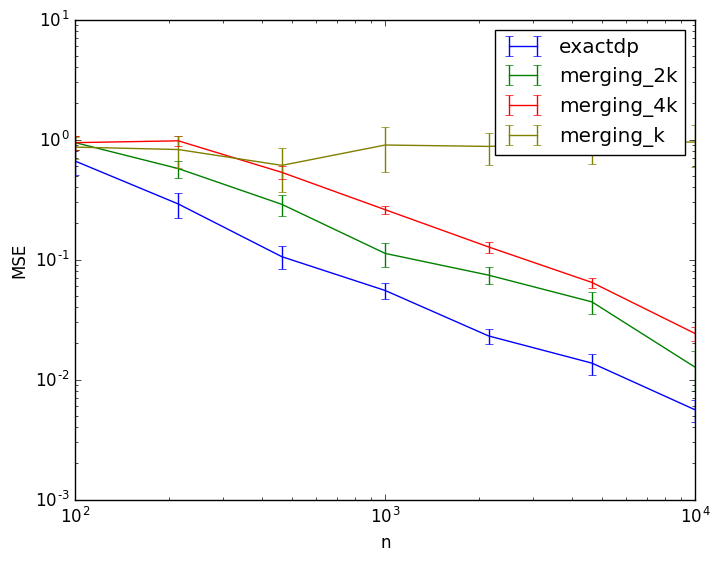

PyObject <matplotlib.text.Text object at 0x3225b0b10>

In [5]:
for (algo_name, algo_mses) in mses_mean
    errorbar(n_vals, algo_mses, yerr=mses_std[algo_name], label=algo_name, color=algo_colors[algo_name])
end
#plot(n_vals, 200.0 ./ n_vals, label="C/n")
#plot(n_vals, 5.0 ./ sqrt(n_vals), label="C/sqrt(n)", color="olive")
legend()
yscale("log")
xscale("log")
xlabel("n")
ylabel("MSE")

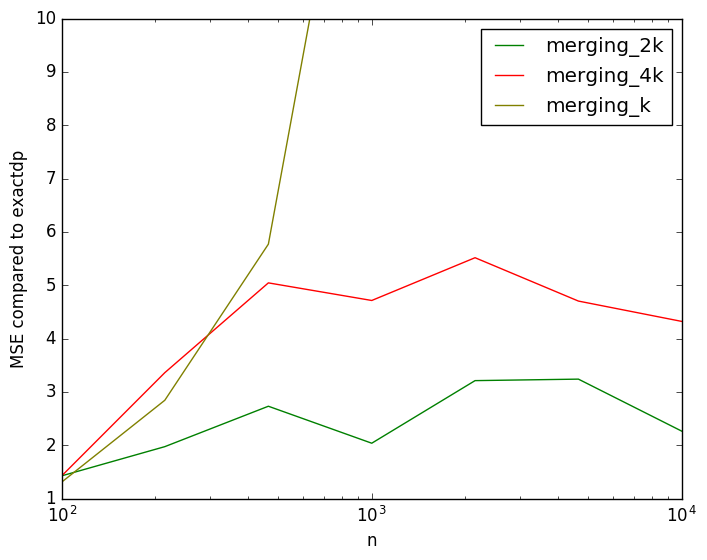

(1,10)

In [10]:
exactdp_mses = mses_mean["exactdp"]
for (algo_name, algo_mses) in mses_mean
    if algo_name != "exactdp"
        plot(n_vals, algo_mses ./ exactdp_mses, label=algo_name, color=algo_colors[algo_name])
    end
end
legend()
xscale("log")
xlabel("n")
ylabel("MSE compared to exactdp")
ylim([1, 10])

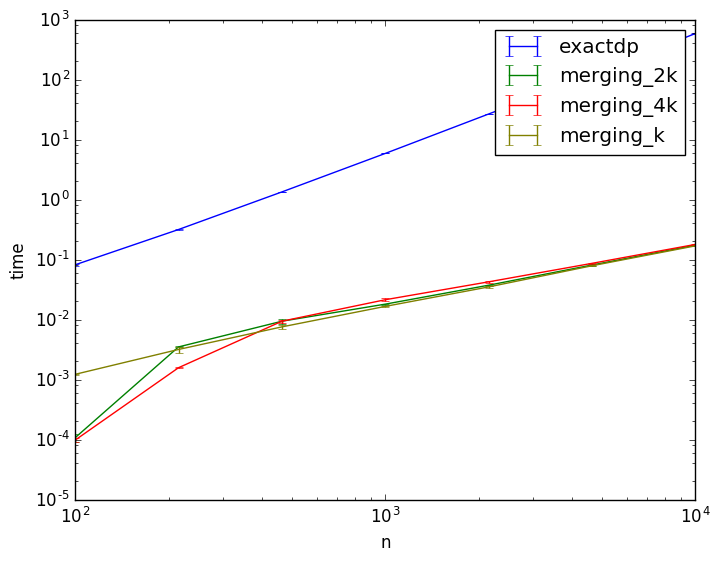

PyObject <matplotlib.text.Text object at 0x326ff7790>

In [11]:
for (algo_name, algo_times) in times_mean
    errorbar(n_vals, algo_times, yerr=times_std[algo_name], label=algo_name, color=algo_colors[algo_name])
end
legend()
yscale("log")
xscale("log")
xlabel("n")
ylabel("time")

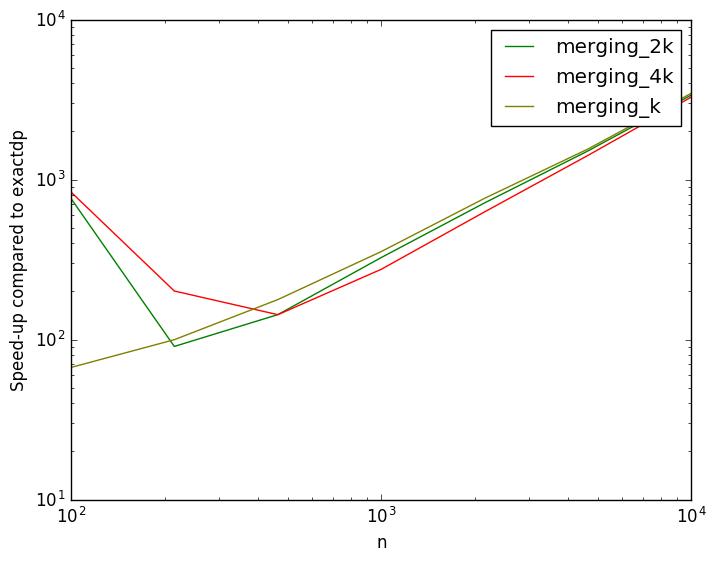

PyObject <matplotlib.text.Text object at 0x327511590>

In [12]:
exactdp_times = times_mean["exactdp"]
for (algo_name, algo_times) in times_mean
    if algo_name != "exactdp"
        plot(n_vals, exactdp_times ./ algo_times, label=algo_name, color=algo_colors[algo_name])
    end
end
legend()
yscale("log")
xscale("log")
xlabel("n")
ylabel("Speed-up compared to exactdp")

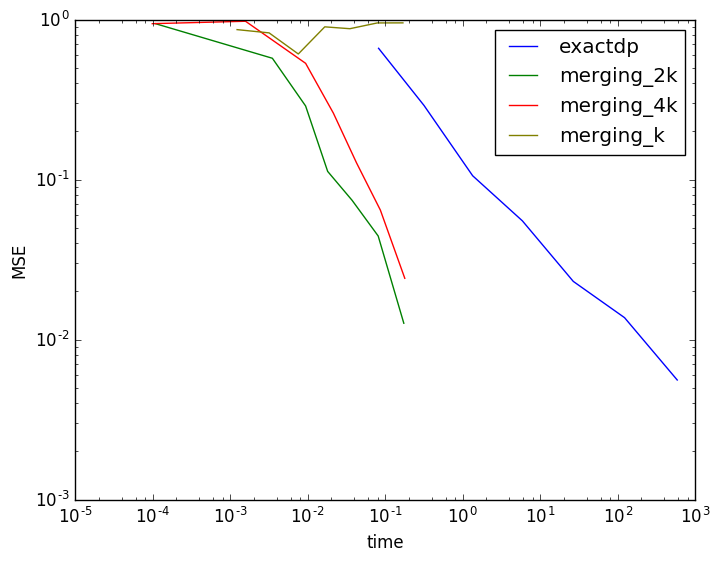

PyObject <matplotlib.text.Text object at 0x327c2d950>

In [13]:
for (algo_name, algo_times) in times_mean
    plot(algo_times, mses_mean[algo_name], label=algo_name, color=algo_colors[algo_name])
end
legend()
yscale("log")
xscale("log")
xlabel("time")
ylabel("MSE")

In [12]:
mean_mses["exactdp"]

5-element Array{Float64,1}:
 0.287982 
 0.137906 
 0.117015 
 0.0412379
 0.0370705

In [13]:
mean_mses["merging_2k"]

5-element Array{Float64,1}:
 0.41039  
 0.300134 
 0.175501 
 0.0905758
 0.0448096

In [14]:
0.0217 / 0.0059

3.6779661016949152

In [15]:
0.359 / 0.097

3.7010309278350513

In [16]:
n_vals

5-element Array{Int64,1}:
  100
  178
  316
  562
 1000

In [17]:
mean_times["exactdp"]

5-element Array{Float64,1}:
  0.116775
  0.417549
  1.44858 
  5.00096 
 18.1487  

In [18]:
mean_times["merging_2k"]

5-element Array{Float64,1}:
 0.0012622 
 0.00179161
 0.00346793
 0.00531922
 0.00946281

In [19]:
mean_times["exactdp"][6] / mean_times["merging_2k"][6]

LoadError: LoadError: BoundsError: attempt to access 5-element Array{Float64,1}:
  0.116775
  0.417549
  1.44858 
  5.00096 
 18.1487  
  at index [6]
while loading In[19], in expression starting on line 1

In [24]:
extra_algos = Dict([("merging_k", merging_k), ("merging_2k", merging_2k), ("merging_4k", merging_4k)])
extra_n_vals = round(Int, logspace(4.0, 6.0, 7))
extra_mses = Dict{ASCIIString, Array{Float64, 2}}()
extra_times = Dict{ASCIIString, Array{Float64, 2}}()

for algo_name in keys(extra_algos)
    extra_mses[algo_name] = Array(Float64, length(extra_n_vals), num_trials * num_data_sets)
    extra_times[algo_name] = Array(Float64, length(extra_n_vals), num_trials * num_data_sets)
end

# Warm-up for pre-compilation
n_warmup = 1000
y, ystar, X = generate_equal_size_random_regression_data(k, n_warmup, d, sigma);
@printf("Warm-up with n = %d\n", n_warmup)
for (algo_name, algo_fun) in extra_algos
    yhat_partition = algo_fun(X, y, k)
end

for (nii, n) in enumerate(extra_n_vals)
    @printf("n = %d  ", n)
    
    tic()
    for iidata = 1:num_data_sets
        bin_values = rand(1:10, k);
        @printf("*")
        
        for ii = 1:num_trials
            #@printf("  trial %d\n", ii)
            @printf(".")
            y, ystar, X = generate_equal_size_random_regression_data(k, n, d, sigma);

            for (algo_name, algo_fun) in extra_algos
                #@printf("    algorithm %s\n", algo_name)
                start_time = time_ns()
                yhat_partition = algo_fun(X, y, k)
                end_time = time_ns()
                yhat = partition_to_vector(X, yhat_partition)
                extra_mses[algo_name][nii, (iidata - 1) * num_trials + ii] = mse(yhat, ystar)
                extra_times[algo_name][nii, (iidata - 1) * num_trials + ii] = 1e-9 * (end_time - start_time)
            end
        end
    end
    elapsed = toq()
    @printf("  %f seconds\n", elapsed)
end

extra_mses_mean = Dict{AbstractString, Array{Float64, 1}}()
extra_mses_std = Dict{AbstractString, Array{Float64, 1}}()
extra_times_mean = Dict{AbstractString, Array{Float64, 1}}()
extra_times_std = Dict{AbstractString, Array{Float64, 1}}()
for algo_name in keys(extra_mses)
    extra_mses_mean[algo_name] = vec(mean(extra_mses[algo_name], 2))
    extra_mses_std[algo_name] = vec(std(extra_mses[algo_name], 2))
    extra_times_mean[algo_name] = vec(mean(extra_times[algo_name], 2))
    extra_times_std[algo_name] = vec(std(extra_times[algo_name], 2))
end

Warm-up with n = 1000
n = 10000  *..........  5.591857 seconds
n = 21544  *..........  12.133463 seconds
n = 46416  *..........  25.717509 seconds
n = 100000  *..........  55.127723 seconds
n = 215443  *..........  126.607694 seconds
n = 464159  *..........  264.962442 seconds
n = 1000000  *..........  579.218262 seconds


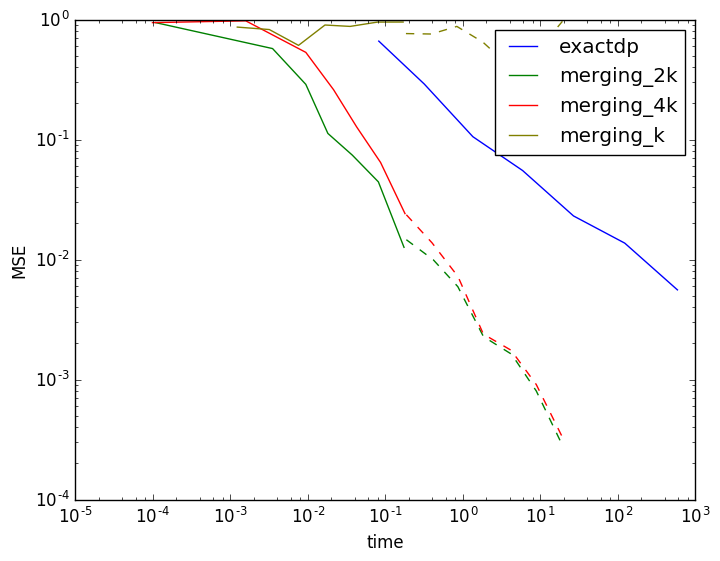

PyObject <matplotlib.text.Text object at 0x328d6c510>

In [25]:
for (algo_name, algo_times) in times_mean
    plot(algo_times, mses_mean[algo_name], label=algo_name, color=algo_colors[algo_name])
end
for (algo_name, algo_times) in extra_times_mean
    plot(algo_times, extra_mses_mean[algo_name], color=algo_colors[algo_name], linestyle="--")
end
legend()
yscale("log")
xscale("log")
xlabel("time")
ylabel("MSE")

In [27]:
X = zeros(1,1)
ystar = yhat = y = zeros(1)

@save "experiments5_k5.jld"

In [32]:
include("../src/helpers.jl")

write_experiment_data_with_ratios (generic function with 1 method)

In [33]:
for algo_name in keys(algos)
    write_experiment_data_with_ratios("experiments5_k5", algo_name, "exactdp", n_vals, mses_mean, mses_std, times_mean, times_std)
end

In [31]:
for algo_name in keys(extra_algos)
    write_experiment_data("experiments5_k5_extra", algo_name, extra_n_vals, extra_mses_mean, extra_mses_std, extra_times_mean, extra_times_std)
end